# Scenario evaluation

In [1]:
!make -C .. scenarios

make: Entering directory '/home/martibosch/data-science/lausanne-greening-scenarios'
make: Nothing to be done for 'scenarios'.
make: Leaving directory '/home/martibosch/data-science/lausanne-greening-scenarios'


In [2]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from scipy import stats

from lausanne_greening_scenarios import utils

In [3]:
scenario_ds_filepath = '../data/processed/scenarios.nc'
biophysical_table_filepath = '../data/processed/biophysical-table.csv'

In [4]:
scenario_ds = xr.open_dataset(scenario_ds_filepath)
biophysical_df = pd.read_csv(biophysical_table_filepath)

In [5]:
num_change_props = 4
change_props = np.linspace(0, 1, num_change_props + 1)

start_ds = scenario_ds.sel(change_prop=0).isel(interaction=0,
                                               scenario_run=0,
                                               drop=True)
_plot_ds = scenario_ds.sel(change_prop=change_props[1:])

## 1. LULC change

### 1.1 Average out of all the simulation runs and sampling approaches

In [6]:
# prepare a LULC change df which counts the number of pixels of each LULC
# class changed for each proportion of upgraded pixels
# for proportions of changed pixels other than 0 or 1, we need to
# consider each scenario run to build the confidence intervals in the bar
# plot
lulc_df = pd.concat([
    pd.concat([
        pd.concat([
            pd.DataFrame({
                'scenario_run': _scenario_run,
                **{
                    key: values
                    for key, values in zip(['lucode', 'num_pixels'],
                                           np.unique(_lulc_da,
                                                     return_counts=True))
                }
            }) for _scenario_run, _lulc_da in change_prop_da.where(
                change_prop_da != start_ds['LULC'],
                start_ds['LULC'].attrs['nodata']).groupby('scenario_run')
        ]).assign(change_prop=change_prop) for change_prop, change_prop_da in
        interaction_da.groupby('change_prop')
    ]).assign(interaction=interaction)
    for interaction, interaction_da in _plot_ds['LULC'].groupby('interaction')
]).merge(biophysical_df[['lucode', 'description']], on='lucode').groupby(
    ['description', 'scenario_run', 'change_prop',
     'interaction'])['num_pixels'].sum().reset_index()

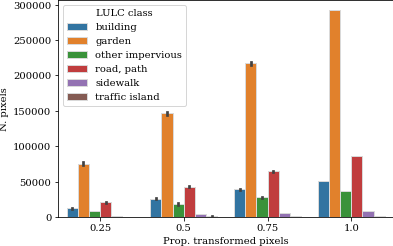

In [7]:
ax = sns.barplot(x='change_prop', y='num_pixels', hue='description', data=lulc_df)
ax.set_xlabel('Prop. transformed pixels')
ax.set_ylabel('N. pixels')
ax.legend().set_title('LULC class')
ax.figure.savefig('../reports/figures/scenario-lulc-barplot.pdf')

Let us list the values of the plot (mean and standard deviation, the 95% confidence intervals can be computed out of them):

In [8]:
summary_df = lulc_df.groupby(['change_prop', 'description'
                              ])['num_pixels'].agg(['mean', 'std'])
summary_df

mean          std
change_prop description                                 
0.25        building           12185.900000  1894.113410
            garden             75264.933333  6489.783669
            other impervious    8508.300000  1987.247501
            road, path         20758.600000  1971.048323
            sidewalk            1847.866667   445.449849
            traffic island       314.400000   198.719279
0.50        building           25708.933333  2067.248795
            garden            146213.233333  7496.285888
            other impervious   18269.433333  2366.932478
            road, path         42852.533333  2323.425559
            sidewalk            3971.133333   515.277410
            traffic island       744.733333   228.592083
0.75        building           39197.766667  1879.255569
            garden            217265.433333  6497.511066
            other impervious   28054.633333  2008.398049
            road, path         64857.033333  1987.258109
            sidewalk            6090.066667   431.378539
            traffic island      1175.066667   195.676533
1.00        building           51416.000000     0.000000
            garden            292459.000000     0.000000
            other impervious   36568.000000     0.000000
            road, path         85659.000000     0.000000
            sidewalk            7932.000000     0.000000
            traffic island      1486.000000     0.000000

Let us now compute the total number of pixels transformed for each proportion (which is independent of the sampling approach and simulation run):

In [9]:
total_ser = summary_df.reset_index().groupby('change_prop')['mean'].sum()
total_ser

change_prop
0.25    118880.0
0.50    237760.0
0.75    356640.0
1.00    475520.0
Name: mean, dtype: float64

Finally, let us list, for each proportion of transformed pixels, the share of transformed pixels by their original LULC class (averaged over all sampling approaches and simulation runs):

In [10]:
summary_df['mean'].groupby('change_prop').apply(
    lambda g: g / total_ser.loc[g.name])

change_prop  description     
0.25         building            0.102506
             garden              0.633117
             other impervious    0.071570
             road, path          0.174618
             sidewalk            0.015544
             traffic island      0.002645
0.50         building            0.108130
             garden              0.614961
             other impervious    0.076840
             road, path          0.180234
             sidewalk            0.016702
             traffic island      0.003132
0.75         building            0.109908
             garden              0.609201
             other impervious    0.078664
             road, path          0.181856
             sidewalk            0.017076
             traffic island      0.003295
1.00         building            0.108126
             garden              0.615030
             other impervious    0.076901
             road, path          0.180138
             sidewalk            0.016681
    

### 1.2 Comparison of sampling approaches

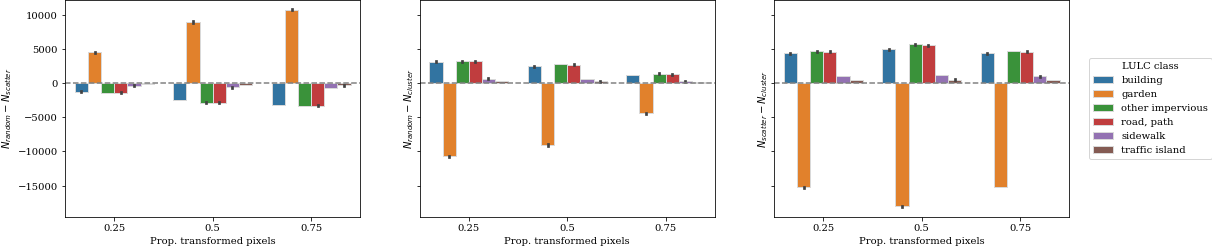

In [11]:
groupby = ['change_prop', 'description']
comparison_df = utils.get_comparison_df(lulc_df, 'num_pixels', sortby=groupby)

fig = utils.plot_approach_comparison(comparison_df, 'change_prop',
                                     'description')
# change x labels
for ax in fig.axes:
    ax.set_xlabel('Prop. transformed pixels')

# legend for only the last axis and outside it
for ax in fig.axes[:-1]:
    ax.get_legend().remove()
ax = fig.axes[-1]
h, l = ax.get_legend_handles_labels()
ax.get_legend().remove()
ax.legend(h,
          l,
          title='LULC class',
          loc='center right',
          bbox_to_anchor=(1.5, .5))
# legend = fig.axes[-1].get_legend()
# legend.set_bbox_to_anchor((1.5, .5))
# legend._set_loc('center right')
    
fig.savefig('../reports/figures/scenario-lulc-barplot-comparison.pdf')

Let us now list the bar heights of the figure above, i.e., the differences between sampling approaches (averaged out of the scenario runs):

In [12]:
utils.get_absolute_comparison_df(comparison_df, groupby, y='num_pixels')

num_pixels  random-scatter  random-cluster  \
change_prop description                                                    
0.25        building             12826.8         -1247.9          3170.6   
            garden               73227.1          4555.1        -10668.6   
            other impervious      9112.2         -1427.7          3239.4   
            road, path           21370.8         -1393.5          3230.1   
            sidewalk              1966.4          -347.1           702.7   
            traffic island         376.7          -138.9           325.8   
0.50        building             25727.4         -2459.6          2515.0   
            garden              146221.9          9038.1         -9012.1   
            other impervious     18269.2         -2849.4          2848.7   
            road, path           42817.2         -2847.6          2741.6   
            sidewalk              3982.7          -602.4           637.1   
            traffic island         741.6          -279.1           269.7   
0.75        building             38555.9         -3155.3          1229.7   
            garden              219384.7         10784.0         -4426.2   
            other impervious     27427.5         -3296.6          1415.2   
            road, path           64203.4         -3303.3          1342.4   
            sidewalk              5954.4          -708.1           301.1   
            traffic island        1114.1          -320.7           137.8   

                              scatter-cluster  
change_prop description                        
0.25        building                   4418.5  
            garden                   -15223.7  
            other impervious           4667.1  
            road, path                 4623.6  
            sidewalk                   1049.8  
            traffic island              464.7  
0.50        building                   4974.6  
            garden                   -18050.2  
            other impervious           5698.1  
            road, path                 5589.2  
            sidewalk                   1239.5  
            traffic island              548.8  
0.75        building                   4385.0  
            garden                   -15210.2  
            other impervious           4711.8  
            road, path                 4645.7  
            sidewalk                   1009.2  
            traffic island              458.5

Let us list the same information in relative terms, i.e., the share of pixels of each LULC class transformed on average for all sampling approaches and scenario runs:

In [13]:
utils.get_relative_comparison_df(comparison_df,
                                 groupby,
                                 'num_pixels',
                                 by_group_totals=True)

random-scatter  random-cluster  scatter-cluster
change_prop description                                                      
0.25        building               -0.001050        0.002667         0.003717
            garden                  0.003832       -0.008974        -0.012806
            other impervious       -0.001201        0.002725         0.003926
            road, path             -0.001172        0.002717         0.003889
            sidewalk               -0.000292        0.000591         0.000883
            traffic island         -0.000117        0.000274         0.000391
0.50        building               -0.001034        0.001058         0.002092
            garden                  0.003801       -0.003790        -0.007592
            other impervious       -0.001198        0.001198         0.002397
            road, path             -0.001198        0.001153         0.002351
            sidewalk               -0.000253        0.000268         0.000521
            traffic island         -0.000117        0.000113         0.000231
0.75        building               -0.000885        0.000345         0.001230
            garden                  0.003024       -0.001241        -0.004265
            other impervious       -0.000924        0.000397         0.001321
            road, path             -0.000926        0.000376         0.001303
            sidewalk               -0.000199        0.000084         0.000283
            traffic island         -0.000090        0.000039         0.000129

## 2. Maps

In [14]:
def _get_mode(data):
    _dims = data.dims[1:]
    return xr.DataArray(stats.mode(data, axis=0).mode[0],
                        dims=_dims,
                        coords={dim: data.coords[dim]
                                for dim in _dims})


_body_plot_ds = _plot_ds.sel(change_prop=change_props[1:-1])
plot_ds = xr.concat([
    xr.Dataset({
        # 'LULC':
        # _body_plot_ds['LULC'].groupby('change_prop').map(_get_mode),
        'LULC':
        _body_plot_ds['LULC'].sel(interaction='random', scenario_run=0),
        'T':
        _body_plot_ds['T'].mean(dim=['interaction', 'scenario_run'])
    }),
    _plot_ds.sel(change_prop=1).sel(interaction='random', scenario_run=0)
],
                    dim='change_prop')

# some arguments for the map plots below
aspect = plot_ds.dims['x'] / plot_ds.dims['y']
cbar_kwargs = {'pad': 0.01}

/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


### 2.1 LULC

/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


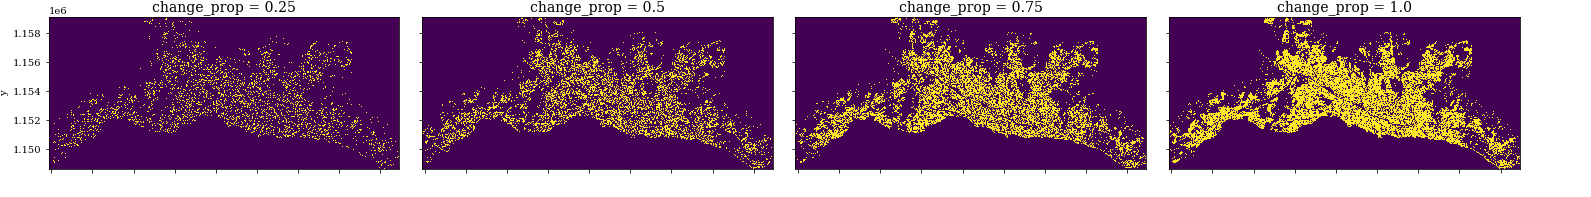

In [15]:
g = (plot_ds['LULC'] - start_ds['LULC']).astype(bool).plot(
    col='change_prop', aspect=aspect, cbar_kwargs=cbar_kwargs)

# post-process figure to be the top row of a facet grid
# begin: set a transparent cbar rather than removing it so that the plot
# columns are aligned with the other plots
# g.cbar.set_alpha(0)
g.cbar.set_label('$T \; [\degree C]$', alpha=0)
g.cbar.outline.set_alpha(0)
g.cbar.patch.set_alpha(0)
g.cbar.solids.set_alpha(0)
g.cbar.ax.yaxis.set_tick_params(color=(0, 0, 0, 0))
cbar_labels = g.cbar.ax.get_yticklabels()
for cbar_label in cbar_labels:
    cbar_label.set_alpha(0)
# now that the labels are invisible, set them to a text of the same length so
# that the plot columns are aligned with the other plots
g.cbar.ax.set_yticklabels(['20.0' for _ in cbar_labels])
# end
g.set_xlabels('')
for ax in g.axes.flat:
    # set transparent labels rather than removing them to have aligned
    for label in ax.get_xticklabels():
        label.set_alpha(0)
    # set transparent offset text (of scientific notation)
    ax.xaxis.get_offset_text().set_alpha(0)
    # set axis title font size
    ax.title.set_size(14)

# save the figure
g.fig.savefig('../reports/figures/scenario-lulc-maps.png')

### 2.2 Temperature

#### 2.2.1 Air temperature

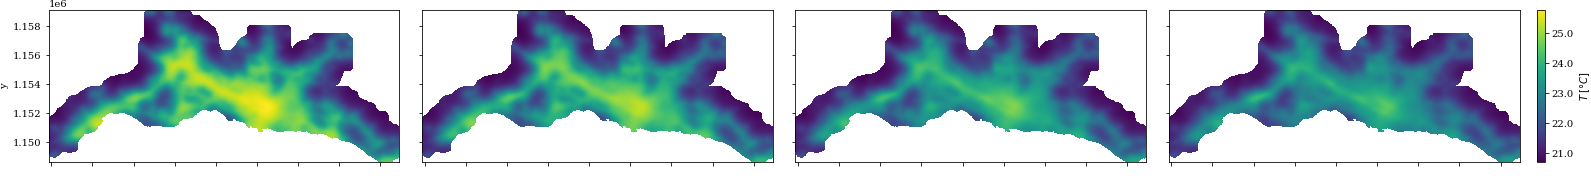

In [16]:
from matplotlib import ticker

g = plot_ds['T'].plot(col='change_prop',
                      aspect=aspect,
                      cbar_kwargs=cbar_kwargs)

# post-process figure to be the middle row of a facet grid
g.cbar.set_label('$T \; [\degree C]$')
# use float labels in the color bar so that the plots are better aligned with
# the other rows
g.cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
g.set_titles('')
g.set_xlabels('')
for ax in g.axes.flat:
    # set transparent labels rather than removing them to have aligned
    for label in ax.get_xticklabels():
        label.set_alpha(0)
    # set transparent offset text (of scientific notation)
    ax.xaxis.get_offset_text().set_alpha(0)

# save the figure
g.fig.savefig('../reports/figures/scenario-T-maps.png')

Let us also list the maximum temperatures (out of all the sampling approaches and scenario runs) for each proportion of transformed pixels:

In [17]:
plot_ds['T'].max(dim=['x', 'y']).to_series()

change_prop
0.25    25.767452
0.50    25.298409
0.75    24.815788
1.00    24.487471
Name: T, dtype: float64

#### 2.2.2 Heat mitigation

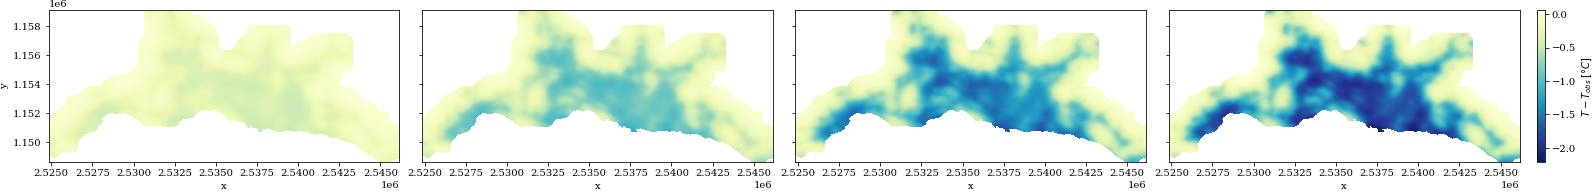

In [18]:
heat_mitigation_da = plot_ds['T'] - start_ds['T']
g = heat_mitigation_da.plot(col='change_prop',
                            vmin=heat_mitigation_da.min(),
                            vmax=heat_mitigation_da.max(),
                            cmap='YlGnBu_r',
                            aspect=aspect,
                            cbar_kwargs=cbar_kwargs)
g.cbar.set_label('$T - T_{obs} \; [\degree C]$')

# post-process figure to be the bottom row of a facet grid
g.set_titles('')

# save the figure
g.fig.savefig('../reports/figures/scenario-heat-mitigation-maps.png')

Let us also list the maximum magnitude of the heat mitigation (out of all the sampling approaches and scenario runs) for each proportion of transformed pixels:

In [19]:
heat_mitigation_da.min(dim=['x', 'y']).to_series()

change_prop
0.25   -0.495312
0.50   -1.166566
0.75   -1.806586
1.00   -2.215052
Name: T, dtype: float64

## 3. Regression plots

In [20]:
df = scenario_ds['T'].mean(dim=['x', 'y'],
                           skipna=True).to_dataframe().reset_index()

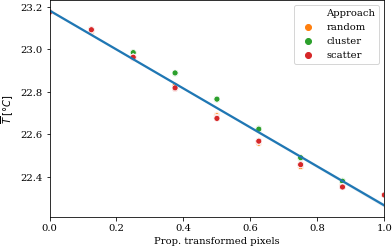

In [21]:
ax = sns.regplot(x='change_prop', y='T', data=df, scatter=False)
sns.scatterplot(x='change_prop',
                y='T',
                hue='Approach',
                data=df.rename(columns={'interaction': 'Approach'}),
                palette=sns.color_palette()[1:len(df['interaction'].unique()) +
                                            1],
                ax=ax)

ax.set_ylabel('$\\overline{T} \; [\degree C]$')
ax.set_xlabel('Prop. transformed pixels')

ax.figure.savefig('../reports/figures/scenario-T-regplot.pdf', pad_inches=0.02)

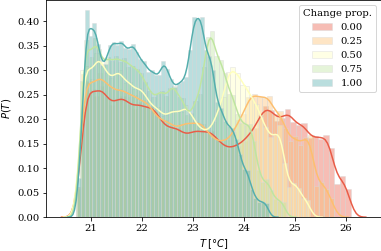

In [22]:
colors = sns.color_palette('Spectral', n_colors=len(change_props))

ax = sns.distplot(start_ds['T'],
                  color=colors[0],
                  label=f'{change_props[0].item():.2f}')
for color, change_prop in zip(colors[1:], change_props[1:]):
    sns.distplot(plot_ds['T'].sel(change_prop=change_prop),
                 color=color,
                 label=f'{change_prop.item():.2f}',
                 ax=ax)

ax.legend(title='Change prop.')
ax.set_ylabel('$P(T)$')
ax.set_xlabel('$T \; [\degree C]$')

ax.figure.savefig('../reports/figures/scenario-T-hists.pdf')